In [ ]:
!kaggle datasets download -d moltean/fruits


Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
 99% 1.88G/1.89G [00:09<00:00, 234MB/s]
100% 1.89G/1.89G [00:09<00:00, 207MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile("fruits.zip", "r") as zip_ref:
    zip_ref.extractall("fruits")


In [ ]:
import torch.nn as nn
import torch
import numpy as np
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
import torch.nn.functional as F
import torch.nn.init as init

In [ ]:
torch.manual_seed(99)

In [ ]:
!pwd


/content


In [ ]:
from torch.utils.data import random_split, DataLoader
transform = transforms.Compose([
    transforms.Resize((75, 75)),
    transforms.ToTensor()
])

data = ImageFolder(root="fruits/fruits-360_100x100/fruits-360/Training",\
                   transform = transform)
print(f"There are {len(data.classes)} classes in total")
print(f"There are {len(data)} pictures in total")
train, val = random_split(data, [int(len(data)*0.85),len(data)-int(len(data)*0.85)])
train_loader = DataLoader(train,batch_size = 1000, shuffle=True,drop_last=True,\
                          num_workers=4,generator=torch.Generator().manual_seed(42))
val_loader = DataLoader(val,batch_size = 1000,drop_last=True,num_workers=4,\
                        generator=torch.Generator().manual_seed(42))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = nn.CrossEntropyLoss()



There are 160 classes in total
There are 79921 pictures in total


In [ ]:
test_data = ImageFolder(root = "fruits/fruits-360_100x100/fruits-360/Test",\
                        transform = transform)
test_loader = DataLoader(test_data,batch_size = 1000,drop_last=True,\
                          num_workers=4,generator=torch.Generator().manual_seed(42))

In [ ]:
import torch.nn as nn
import torchvision.models as models

class TransferModel(nn.Module):
    def __init__(self, model_name="ENB1"):
        super().__init__()
        self.model_name = model_name
        num_classes = 160
        if self.model_name == "ENB1":
            self.original = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)
            # Freeze all parameters of the original model.
            for param in self.original.parameters():
                param.requires_grad = False
            self.extra_layer = nn.Linear(1000, num_classes)

        elif self.model_name == "INCEPV3":
            self.original = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
            # Remove AuxLogits manually after loading the pre-trained model
            self.original.aux_logits = False
            self.original.AuxLogits = None
            for param in self.original.parameters():
                param.requires_grad = False
            self.extra_layer = nn.Linear(1000, num_classes)

        else:
            self.original = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)
            for param in self.original.parameters():
                param.requires_grad = False
            self.extra_layer = nn.Linear(1000, num_classes)

    def forward(self, x):
        original_output = self.original(x)
        out = self.extra_layer(original_output)
        return out


In [ ]:
import torch
import numpy as np  # for np.mean

class Train():
    def __init__(self, model, epochs, device):
        self.device = device
        self.model = model.to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.epochs = epochs
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

    def train(self):
        for epoch in range(self.epochs):
            self.model.train()
            trainloss = 0
            trainacc = 0
            valloss = 0
            valacc = 0

            for batch in train_loader:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)
                preds = self.model(x)
                loss_value = loss(preds, y)
                self.optimizer.zero_grad()
                loss_value.backward()
                self.optimizer.step()
                trainloss += loss_value.item()
                trainacc += (torch.sum(torch.argmax(preds, dim=1) == y).item()) / len(y)

            self.train_loss.append(trainloss / len(train_loader))
            self.train_acc.append(trainacc / len(train_loader))
            self.model.eval()
            with torch.no_grad():
                for batch in val_loader:
                    x, y = batch
                    x, y = x.to(self.device), y.to(self.device)
                    preds = self.model(x)
                    loss_value = loss(preds, y)
                    valloss += loss_value.item()
                    valacc += (torch.sum(torch.argmax(preds, dim=1) == y).item()) / len(y)

            self.val_loss.append(valloss / len(val_loader))
            self.val_acc.append(valacc / len(val_loader))
            print(f"Epoch {epoch+1}/{self.epochs}: "
                  f"Train Loss: {trainloss / len(train_loader):.4f}, Train Acc: {trainacc / len(train_loader):.4f}, "
                  f"Val Loss: {valloss / len(val_loader):.4f}, Val Acc: {valacc / len(val_loader):.4f}")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
model = TransferModel(model_name="ENB1")
trainer = Train(model, epochs=50, device=device)
trainer.train()


Epoch 1/50: Train Loss: 1.1136, Train Acc: 0.7945, Val Loss: 0.0978, Val Acc: 0.9895
Epoch 2/50: Train Loss: 0.1559, Train Acc: 0.9757, Val Loss: 0.0391, Val Acc: 0.9969
Epoch 3/50: Train Loss: 0.0964, Train Acc: 0.9854, Val Loss: 0.0224, Val Acc: 0.9987
Epoch 4/50: Train Loss: 0.0704, Train Acc: 0.9892, Val Loss: 0.0156, Val Acc: 0.9992
Epoch 5/50: Train Loss: 0.0572, Train Acc: 0.9906, Val Loss: 0.0117, Val Acc: 0.9994
Epoch 6/50: Train Loss: 0.0497, Train Acc: 0.9918, Val Loss: 0.0090, Val Acc: 0.9996
Epoch 7/50: Train Loss: 0.0411, Train Acc: 0.9937, Val Loss: 0.0073, Val Acc: 0.9996
Epoch 8/50: Train Loss: 0.0365, Train Acc: 0.9938, Val Loss: 0.0059, Val Acc: 0.9997
Epoch 9/50: Train Loss: 0.0324, Train Acc: 0.9943, Val Loss: 0.0046, Val Acc: 0.9997
Epoch 10/50: Train Loss: 0.0315, Train Acc: 0.9937, Val Loss: 0.0041, Val Acc: 0.9997
Epoch 11/50: Train Loss: 0.0283, Train Acc: 0.9948, Val Loss: 0.0037, Val Acc: 0.9998
Epoch 12/50: Train Loss: 0.0275, Train Acc: 0.9947, Val Loss: 0

In [ ]:
train_acc = trainer.train_acc
train_loss = trainer.train_loss
val_acc = trainer.val_acc
val_loss = trainer.val_loss

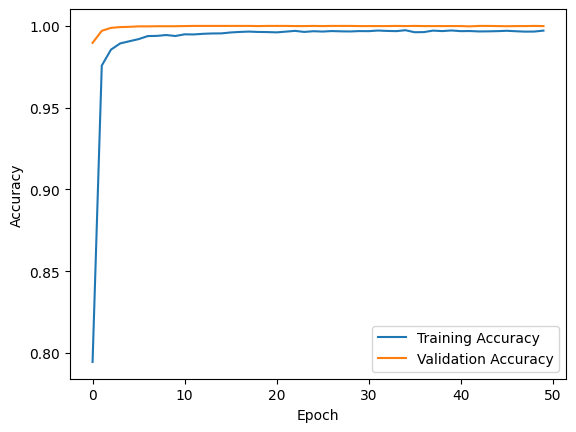

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

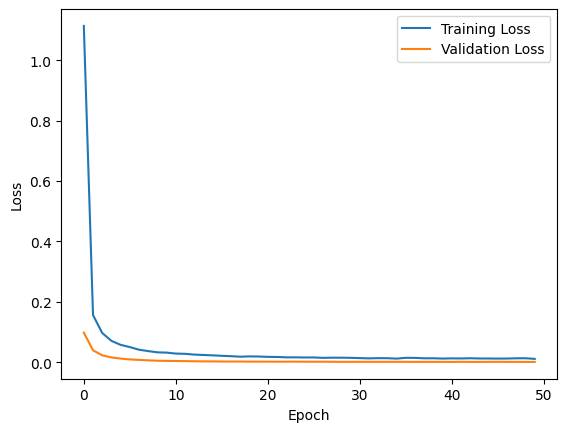

In [ ]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from time import time
start = time()
acc = 0
with torch.no_grad():
  for batch in test_loader:
      x, y = batch
      x, y = x.to(device), y.to(device)  # move data to GPU
      preds = model(x)
      acc += (torch.sum(torch.argmax(preds, dim=1) == y).item()) / len(y)
print(f"Test Accuracy: {acc / len(test_loader)}")
end = time()
t = end - start
print(f"Time taken: {t} seconds")




Test Accuracy: 0.22303846153846155
Time taken: 5.58285927772522 seconds


In [ ]:
model1 = TransferModel(model_name="INCEPV3")
trainer1 = Train(model1, epochs=50, device=device)
trainer1.train()


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 187MB/s] 


Epoch 1/50: Train Loss: 4.3060, Train Acc: 0.1895, Val Loss: 3.7237, Val Acc: 0.4088
Epoch 2/50: Train Loss: 3.4156, Train Acc: 0.3800, Val Loss: 3.1051, Val Acc: 0.5102
Epoch 3/50: Train Loss: 2.9740, Train Acc: 0.4463, Val Loss: 2.7193, Val Acc: 0.5685
Epoch 4/50: Train Loss: 2.6933, Train Acc: 0.4861, Val Loss: 2.4628, Val Acc: 0.6088
Epoch 5/50: Train Loss: 2.5094, Train Acc: 0.5130, Val Loss: 2.2799, Val Acc: 0.6291
Epoch 6/50: Train Loss: 2.3862, Train Acc: 0.5306, Val Loss: 2.1526, Val Acc: 0.6392
Epoch 7/50: Train Loss: 2.2736, Train Acc: 0.5440, Val Loss: 2.0068, Val Acc: 0.6608
Epoch 8/50: Train Loss: 2.1852, Train Acc: 0.5571, Val Loss: 1.9148, Val Acc: 0.6810
Epoch 9/50: Train Loss: 2.1154, Train Acc: 0.5621, Val Loss: 1.8822, Val Acc: 0.6858
Epoch 10/50: Train Loss: 2.0631, Train Acc: 0.5739, Val Loss: 1.7269, Val Acc: 0.7106
Epoch 11/50: Train Loss: 1.9992, Train Acc: 0.5818, Val Loss: 1.7219, Val Acc: 0.7074
Epoch 12/50: Train Loss: 1.9543, Train Acc: 0.5895, Val Loss: 1

In [ ]:
train_acc1 = trainer1.train_acc
train_loss1 = trainer1.train_loss
val_acc1 = trainer1.val_acc
val_loss1 = trainer1.val_loss

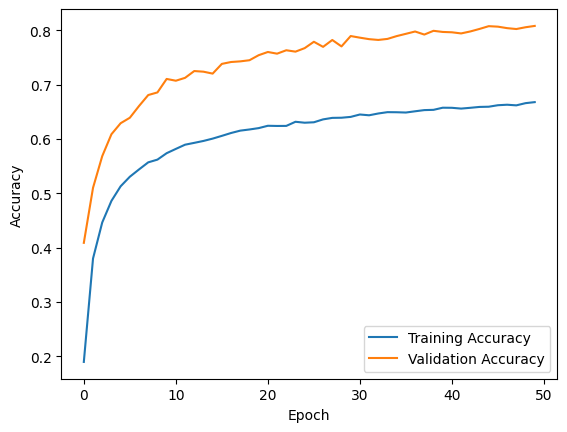

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_acc1, label='Training Accuracy')
plt.plot(val_acc1, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

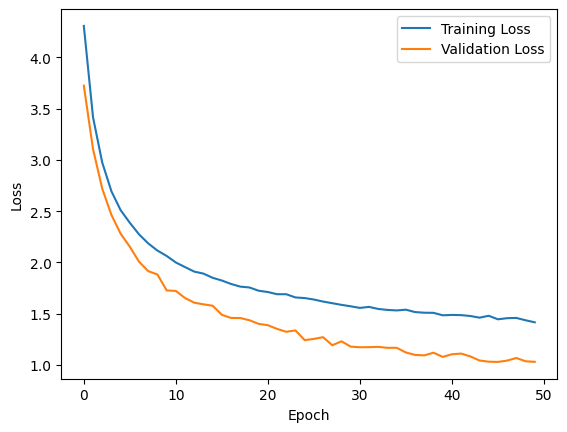

In [ ]:
plt.plot(train_loss1, label='Training Loss')
plt.plot(val_loss1, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from time import time

start = time()
acc1 = 0
model1.eval()
with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        preds = model1(x)
        acc1 += (torch.sum(torch.argmax(preds, dim=1) == y).item()) / len(y)
print(f"Test Accuracy: {acc1 / len(test_loader)}")
end = time()
t1 = end - start
print(f"Time taken: {t1} seconds")


Test Accuracy: 0.15130769230769225
Time taken: 4.961177825927734 seconds


In [ ]:
model2 = TransferModel(model_name="resnet101")
trainer2 = Train(model2, epochs=50, device=device)
trainer2.train()

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 198MB/s]


Epoch 1/50: Train Loss: 1.5824, Train Acc: 0.7799, Val Loss: 0.3998, Val Acc: 0.9584
Epoch 2/50: Train Loss: 0.2872, Train Acc: 0.9774, Val Loss: 0.1997, Val Acc: 0.9864
Epoch 3/50: Train Loss: 0.1592, Train Acc: 0.9903, Val Loss: 0.1085, Val Acc: 0.9920
Epoch 4/50: Train Loss: 0.1038, Train Acc: 0.9950, Val Loss: 0.0776, Val Acc: 0.9952
Epoch 5/50: Train Loss: 0.0692, Train Acc: 0.9973, Val Loss: 0.0631, Val Acc: 0.9969
Epoch 6/50: Train Loss: 0.0560, Train Acc: 0.9979, Val Loss: 0.0518, Val Acc: 0.9975
Epoch 7/50: Train Loss: 0.0420, Train Acc: 0.9986, Val Loss: 0.0360, Val Acc: 0.9980
Epoch 8/50: Train Loss: 0.0343, Train Acc: 0.9990, Val Loss: 0.0392, Val Acc: 0.9985
Epoch 9/50: Train Loss: 0.0294, Train Acc: 0.9993, Val Loss: 0.0308, Val Acc: 0.9985
Epoch 10/50: Train Loss: 0.0244, Train Acc: 0.9994, Val Loss: 0.0258, Val Acc: 0.9987
Epoch 11/50: Train Loss: 0.0230, Train Acc: 0.9994, Val Loss: 0.0226, Val Acc: 0.9989
Epoch 12/50: Train Loss: 0.0200, Train Acc: 0.9997, Val Loss: 0

In [ ]:
train_acc2 = trainer2.train_acc
train_loss2 = trainer2.train_loss
val_acc2 = trainer2.val_acc
val_loss2 = trainer2.val_loss

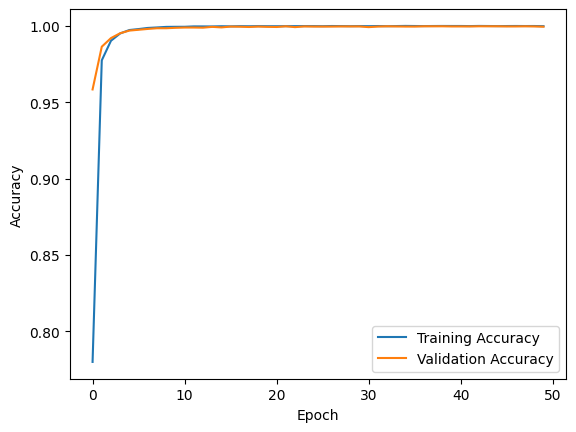

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_acc2, label='Training Accuracy')
plt.plot(val_acc2, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

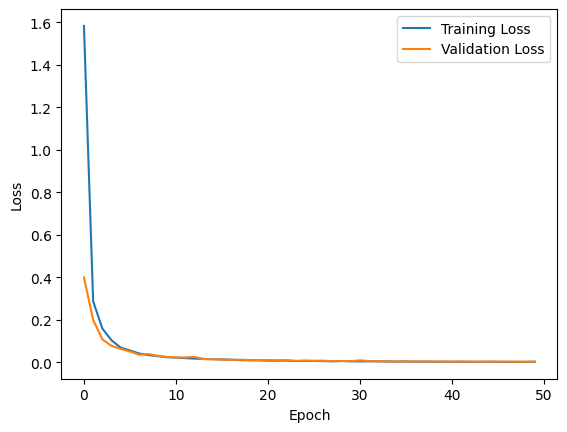

In [ ]:
plt.plot(train_loss2, label='Training Loss')
plt.plot(val_loss2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from time import time

start = time()
acc2 = 0
model2.eval()
with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)  # move data to GPU
        preds = model2(x)
        acc2 += (torch.sum(torch.argmax(preds, dim=1) == y).item()) / len(y)
print(f"Test Accuracy: {acc2 / len(test_loader)}")
end = time()
t2 = end - start
print(f"Time taken: {t2} seconds")

Test Accuracy: 0.2225384615384616
Time taken: 5.0085389614105225 seconds


In [ ]:
param = sum(p.numel() for p in model.parameters())
param1 = sum(p.numel() for p in model1.parameters())
param2 = sum(p.numel() for p in model2.parameters())
print(f"Number of parameters in Efficient Net B1: {param}, t = {t:.5f}, test_acc = {acc/ len(test_loader):.5f}")
print(f"Number of parameters in Inception V3: {param1}, t = {t1:.5f}, test_acc = {acc1 / len(test_loader):.5f}")
print(f"Number of parameters in ResNet 101: {param2}, t = {t2:.5f}, test_acc = {acc2/ len(test_loader):.5f}")

Number of parameters in Efficient Net B1: 7954344, t = 5.58286, test_acc = 0.22304
Number of parameters in Inception V3: 23994728, t = 4.96118, test_acc = 0.15131
Number of parameters in ResNet 101: 44709320, t = 5.00854, test_acc = 0.22254


In [ ]:
table = f"""
| Model             | Number of Parameters | Inference Time (s) | Test Accuracy (%)  |
|-------------------|----------------------|--------------------|--------------------|
| EfficientNet-B1   | {param}              | {t:.5f}            | {acc/len(test_loader)*100:.2f}              |
| Inception V3      | {param1}             | {t1:.5f}            | {acc1/len(test_loader)*100:.2f}              |
| ResNet 101        | {param2}             | {t2:.5f}            | {acc2/len(test_loader)*100:.2f}              |
"""
print(table)



| Model             | Number of Parameters | Inference Time (s) | Test Accuracy (%)  |
|-------------------|----------------------|--------------------|--------------------|
| EfficientNet-B1   | 7954344              | 5.58286            | 22.30              |
| Inception V3      | 23994728             | 4.96118            | 15.13              |
| ResNet 101        | 44709320             | 5.00854            | 22.25              |



In [ ]:
!pip install datasets transformers


In [ ]:
!pip install datasets transformers evaluate


In [ ]:

import numpy as np
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset

import evaluate

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments


raw_datasets = load_dataset("imdb")

full_train_dataset = raw_datasets["train"].shuffle(seed=42)
val_dataset = full_train_dataset.select(range(1000))
train_dataset = full_train_dataset.select(range(1000, len(full_train_dataset)))
test_dataset = raw_datasets["test"]

# Tokenize the dataset using ALBERT's tokenizer
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

def tokenize_function(examples):
    # Tokenize the text reviews. We use max_length to pad/truncate the texts.
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

columns = ["input_ids", "attention_mask", "label"]
train_dataset.set_format(type="torch", columns=columns)
val_dataset.set_format(type="torch", columns=columns)
test_dataset.set_format(type="torch", columns=columns)

# Load ALBERT pretrained
model = AutoModelForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)


training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

accuracy_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: gezhiwang103 (gezhiwang103-cornell-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.224400,0.237343,0.925000
2,0.170800,0.320603,0.932000
3,0.112300,0.345524,0.929000
4,0.070400,0.406264,0.932000
5,0.077000,0.486197,0.924000
6,0.044800,0.531731,0.937000
7,0.012900,0.606719,0.933000
8,0.000700,0.660702,0.931000
9,0.000000,0.678557,0.933000
10,0.000000,0.671036,0.936000


TrainOutput(global_step=15000, training_loss=0.07446481683701277, metrics={'train_runtime': 5036.4436, 'train_samples_per_second': 47.653, 'train_steps_per_second': 2.978, 'total_flos': 5735544422400000.0, 'train_loss': 0.07446481683701277, 'epoch': 10.0})

In [ ]:
test_results = trainer.evaluate(eval_dataset=test_dataset)
print("Test evaluation:", test_results)

history = trainer.state.log_history

epochs = []
train_losses = []
val_losses = []
val_accuracies = []

for log in history:
    if "epoch" in log:
        epoch = log["epoch"]
        if "loss" in log and "eval_loss" not in log:
            epochs.append(epoch)
            train_losses.append(log["loss"])
        if "eval_loss" in log:
            val_losses.append(log["eval_loss"])
            val_accuracies.append(log.get("eval_accuracy", None))




Test evaluation: {'eval_loss': 0.4668540954589844, 'eval_accuracy': 0.9374, 'eval_runtime': 175.1516, 'eval_samples_per_second': 142.734, 'eval_steps_per_second': 8.924, 'epoch': 10.0}


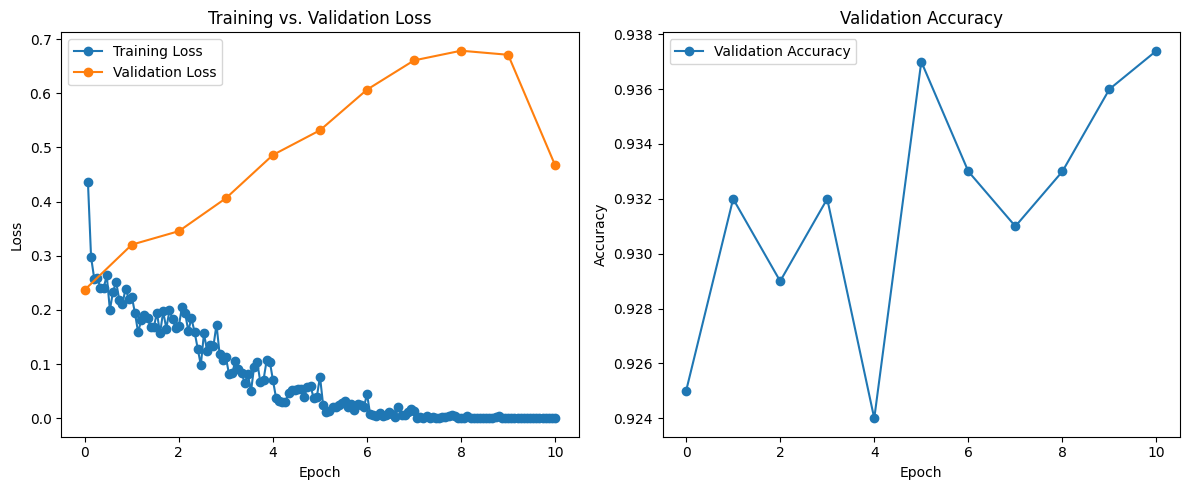

Bonus Prediction:
Predicted label (0=negative, 1=positive): 1
Class probabilities: [0.00011624566104728729, 0.999883770942688]


In [ ]:
plt.figure(figsize=(12, 5))

x1=np.arange(len(val_losses))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss", marker='o')
plt.plot(x1, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()

x2=np.arange(len(val_accuracies))
plt.subplot(1, 2, 2)
plt.plot(x2, val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

#Bonus
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sample_text = "This movie was really amazing!"
inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
inputs = {key: value.to(device) for key, value in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()
probabilities = torch.softmax(logits, dim=1).squeeze().tolist()

print("Bonus Prediction:")
print("Predicted label (0=negative, 1=positive):", predicted_class)
print("Class probabilities:", probabilities)


In [ ]:
sample_text = "asian people"
inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
inputs = {key: value.to(device) for key, value in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()
probabilities = torch.softmax(logits, dim=1).squeeze().tolist()

print("Bonus Prediction:")
print("Predicted label (0=negative, 1=positive):", predicted_class)
print("Class probabilities:", probabilities)

Bonus Prediction:
Predicted label (0=negative, 1=positive): 1
Class probabilities: [0.13353025913238525, 0.8664697408676147]
